In [1]:
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor

# 加载数据
train_val_data = pd.read_csv('D:\\2024test.csv')
X_train_val = train_val_data.drop(columns=['O3','date'])
y_train_val = train_val_data['O3']

test_data = pd.read_csv('D:\\2025test.csv')
X_test = test_data.drop(columns=['O3','date'])
y_test = test_data['O3']

# 时间序列划分
n_samples = len(X_train_val)
train_size = int(n_samples * 0.9)
X_train, X_val = X_train_val.iloc[:train_size], X_train_val.iloc[train_size:]
y_train, y_val = y_train_val.iloc[:train_size], y_train_val.iloc[train_size:]

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.7, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'random_state': 42,
        'verbose': False
    }
    
    # 根据bootstrap_type调整参数
    if params['bootstrap_type'] == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0.0, 1.0)
    elif params['bootstrap_type'] == 'Bernoulli':
        params['subsample'] = trial.suggest_float('subsample', 0.7, 1.0)
    
    model = CatBoostRegressor(**params)
    
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    
    for train_idx, val_idx in tscv.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(
            X_train_fold, 
            y_train_fold,
            eval_set=(X_val_fold, y_val_fold),
            early_stopping_rounds=50,
            verbose=False
        )
        
        y_pred = model.predict(X_val_fold)
        score = r2_score(y_val_fold, y_pred)
        scores.append(score)
    
    return np.mean(scores)

# 创建Optuna研究对象
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 输出最优超参数
print("最优超参数：", study.best_params)
print("最优R2值（交叉验证）：", study.best_value)

# 训练最终模型
final_params = study.best_params.copy()

# 移除可能存在的冲突参数
for param in ['early_stopping_rounds', 'eval_metric']:
    if param in final_params:
        del final_params[param]

#print(f"测试集RMSE: {test_rmse:.4f}")  # 新增RMSE输出

[I 2025-07-10 16:39:27,084] A new study created in memory with name: no-name-36e24b13-cafc-4263-88a9-c15e08af36a8
[I 2025-07-10 16:39:40,334] Trial 0 finished with value: 0.7886659698926245 and parameters: {'iterations': 279, 'depth': 8, 'learning_rate': 0.038854698606880116, 'colsample_bylevel': 0.9828618657709747, 'l2_leaf_reg': 0.8913918657911033, 'min_data_in_leaf': 9, 'random_strength': 0.5482966327881234, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.7886659698926245.
[I 2025-07-10 16:39:44,931] Trial 1 finished with value: 0.7801676603514951 and parameters: {'iterations': 458, 'depth': 4, 'learning_rate': 0.1355190727236083, 'colsample_bylevel': 0.7148878330906709, 'l2_leaf_reg': 0.8372214485208895, 'min_data_in_leaf': 1, 'random_strength': 0.8451616007692567, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8593857215551781}. Best is trial 0 with value: 0.7886659698926245.
[I 2025-07-10 16:39:50,404] Trial 2 fin

最优超参数： {'iterations': 420, 'depth': 6, 'learning_rate': 0.0733964487112684, 'colsample_bylevel': 0.8538489792848775, 'l2_leaf_reg': 0.44166648583611234, 'min_data_in_leaf': 1, 'random_strength': 0.8106961491639276, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS'}
最优R2值（交叉验证）： 0.7967035321487794


NameError: name 'test_rmse' is not defined

0:	learn: 39.1655306	test: 37.9287691	best: 37.9287691 (0)	total: 7.21ms	remaining: 3.02s
100:	learn: 14.1317575	test: 13.8540058	best: 13.8340151 (79)	total: 690ms	remaining: 2.18s
200:	learn: 12.6850517	test: 13.4929426	best: 13.4912393 (199)	total: 1.38s	remaining: 1.5s
300:	learn: 11.8217035	test: 13.4397680	best: 13.4272222 (296)	total: 1.96s	remaining: 774ms
400:	learn: 11.1840443	test: 13.3904676	best: 13.3785022 (370)	total: 2.54s	remaining: 120ms
419:	learn: 11.0772947	test: 13.3770994	best: 13.3706110 (417)	total: 2.64s	remaining: 0us

bestTest = 13.37061103
bestIteration = 417

Shrink model to first 418 iterations.
测试集性能指标:
R² = 0.8270
RMSE = 16.8042
MAE = 12.1162


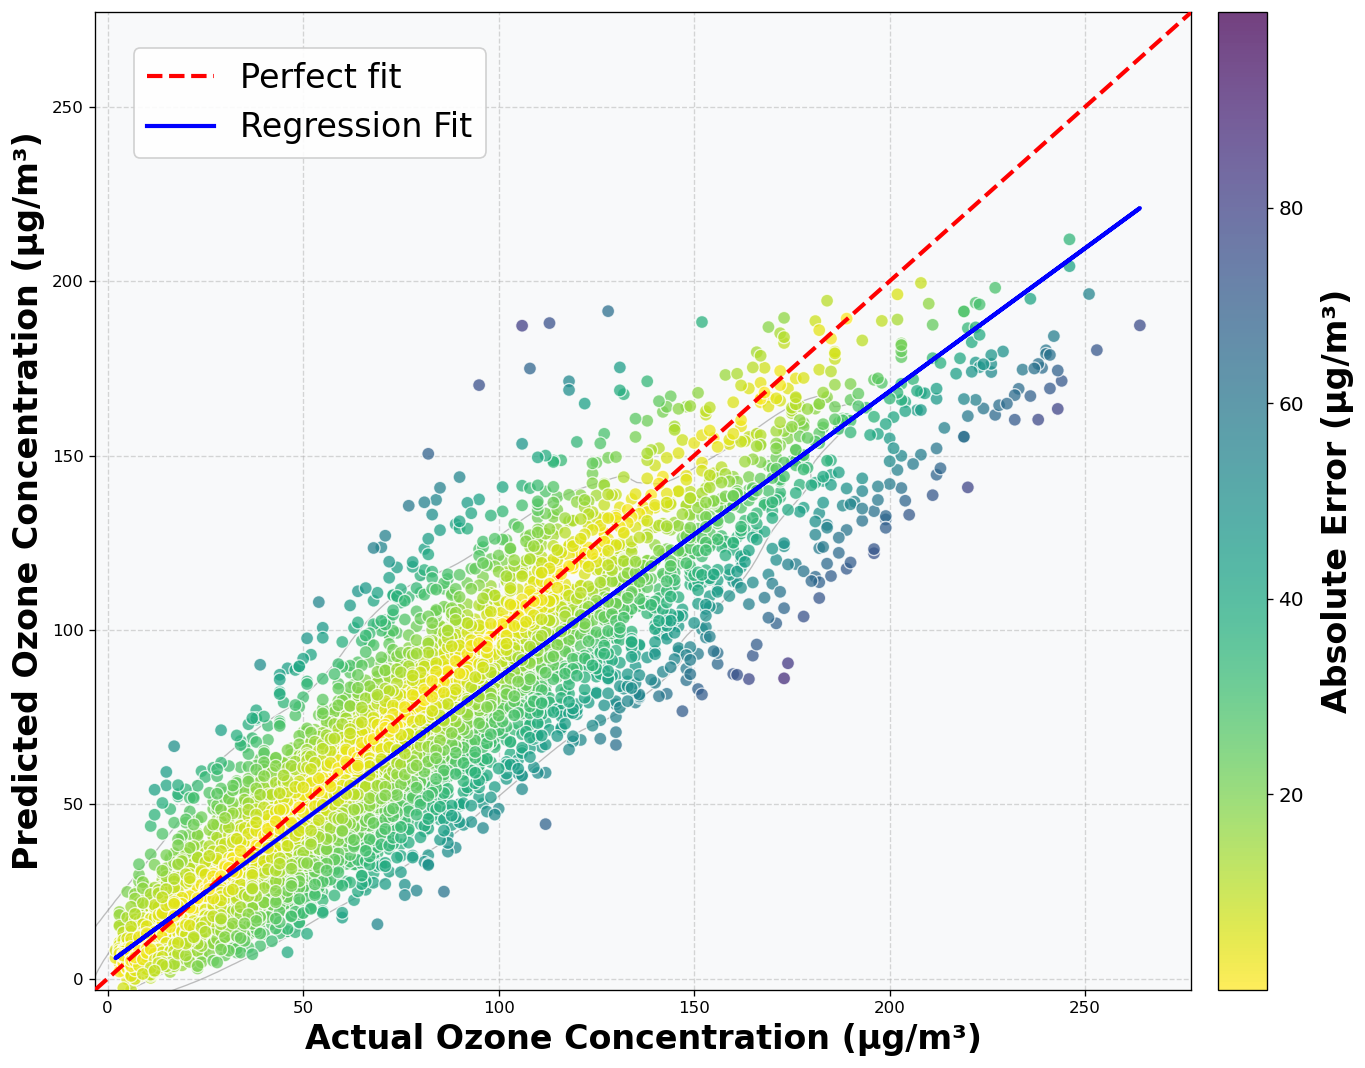

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math
import matplotlib.font_manager as fm

# 设置全局绘图参数
plt.figure(figsize=(12, 9), dpi=120)
plt.rcParams['font.family'] = 'DejaVu Sans'  # 使用支持中文的字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 使用最优超参数训练最终模型（在完整训练集上）
final_model = CatBoostRegressor(**final_params)
final_model.fit(
    X_train, 
    y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=50,
    verbose=100
)

# 在测试集上进行预测
y_pred = final_model.predict(X_test)

# 计算测试集性能指标
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"测试集性能指标:")
print(f"R² = {test_r2:.4f}")
print(f"RMSE = {test_rmse:.4f}")
print(f"MAE = {test_mae:.4f}")

# 1. 创建散点图（专业风格）
scatter = plt.scatter(y_test, y_pred, 
                    c=np.abs(y_test - y_pred),  # 颜色表示误差大小
                    cmap='viridis_r',  # 反转色图，使高误差更明显
                    alpha=0.75, 
                    s=60, 
                    edgecolor='w', 
                    linewidth=0.8,
                    zorder=3)  # 设置图层顺序

# 2. 添加完美拟合线（红色虚线）
min_val = min(y_test.min(), y_pred.min()) * 0.95
max_val = max(y_test.max(), y_pred.max()) * 1.05
perfect_fit, = plt.plot([min_val, max_val], [min_val, max_val], 
                      'r--', linewidth=2.5, label='Perfect fit', zorder=5)  # 较高图层顺序

# 3. 添加回归拟合线（蓝色实线）
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, y_pred)
reg_line = slope * y_test + intercept
reg_fit, = plt.plot(y_test, reg_line, 
                  'b-', linewidth=2.5, 
                  label='Regression Fit', zorder=5)  # 较高图层顺序

# 计算两条线之间的夹角
m1 = 1.0  # 完美拟合线斜率 (y = x)
m2 = slope  # 回归线斜率

# 避免除零错误
if abs(1 + m1 * m2) > 1e-6:
    angle_rad = abs(math.atan((m2 - m1) / (1 + m1 * m2)))
    angle_deg = abs(math.degrees(angle_rad))
else:
    angle_deg = 90.0  # 线垂直

# 4. 添加颜色条
cbar = plt.colorbar(scatter, pad=0.02)
cbar.set_label('Absolute Error (μg/m³)', fontsize=20, labelpad=10, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

# 设置颜色条范围为0-100（可选，因为散点图已经设置了vmin/vmax）
cbar.mappable.set_clim(0, 100)  # 正确的方法是在mappable对象上设置

# 设置自定义刻度：只显示20,40,60,80
cbar.set_ticks([20, 40, 60, 80])
cbar.set_ticklabels(['20', '40', '60', '80'])


# 5. 计算并显示评估指标
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 创建评估指标文本
#metrics_text = (
#    f'$R^2$ = {r2:.3f}\n'
#    f'RMSE = {rmse:.2f} μg/m³\n'
#    f'MAE = {mae:.2f} μg/m³\n'
#    f'sample = {len(y_test)}\n'
#    f'angle = {angle_deg:.1f}°'
#)

# 添加半透明文本框
#plt.text(0.05, 0.95, metrics_text, 
#        transform=plt.gca().transAxes, fontsize=14,
#        verticalalignment='top',
#        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 6. 设置主图标签和标题
plt.xlabel('Actual Ozone Concentration (μg/m³)', fontsize=20, weight='bold')
plt.ylabel('Predicted Ozone Concentration (μg/m³)', fontsize=20, fontweight='bold')
#plt.title('CatBoost Optimized Model Performance', fontsize=16, pad=15)

# 7. 添加图例（位置优化）
#plt.legend(loc='lower right', fontsize=12, frameon=True, framealpha=0.9)
plt.legend(loc='upper left',bbox_to_anchor=(0.02, 0.98), fontsize=20, frameon=True, framealpha=0.9)
# 8. 设置网格和背景
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_facecolor('#f8f9fa')

# 9. 设置坐标轴范围
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# 10. 添加数据点密度等高线（可选）
# 如果数据点密集，可以添加等高线显示密度分布
if len(y_test) > 100:
    sns.kdeplot(x=y_test, y=y_pred, 
                levels=5, color='gray', 
                alpha=0.5, linewidths=0.8)


# 优化布局并保存
plt.tight_layout()
plt.savefig('catboost_optimized_performance.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 特征重要性图
feature_importance = final_model.get_feature_importance()
feature_names = X_train.columns
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(12, 8))
plt.barh(range(15), feature_importance[sorted_idx][:15], align='center')
plt.yticks(range(15), np.array(feature_names)[sorted_idx][:15])
plt.xlabel('特征重要性')
plt.title('Top 15 特征重要性 (CatBoost)')
plt.gca().invert_yaxis()  # 最重要的特征在顶部
plt.tight_layout()
plt.savefig('catboost_feature_importance.png', dpi=300)
plt.show()